In [1]:
from src import *

In [16]:
def get_aggprop(h5dict, property):
    """
    Get the bundles statistics on whole brain level
    """
    try:
        ret = np.array(h5dict.get('matrices').get(property))
    except:
        print('Not valid property OR h5 not opened')
    return ret

def get_bundles_betweenreg(h5dict, r1, r2, verbose=True):
    """
    Get the bundles voxels spots linking two regions of interest
    """

    bundle_r = str(r1) + '_' + str(r2)

    # Check if bundle link exists
    feasible = np.array(list(set(np.array(h5dict.get('atlas')))))
    valid_regions = set([f.split('_')[0] for f in feasible] + [f.split('_')[1] for f in feasible])

    if not ((str(r1) in valid_regions) and (str(r2) in valid_regions)):
        if verbose: print('Regions inputed are not valid')
        return

    if bundle_r not in feasible:
        if verbose: print('Regions {} and {} are not sufficiently connected'.format(r1, r2))
        return
    

    ret = np.array(h5dict.get('atlas').get(bundle_r))
    return ret

## Goal

The goal of this notebook is to ...

## Description



- Scale1 -> ~95
- Scale2 -> ~140
- Scale3 -> ~240

Structuring of folder h5: 
- ['atlas', 'header', 'matrices']:
    - atlas:
        - bundles 10-59
        - bundles 11-23
        - ...
    - header: 
        - affine, dim, gmcodes, gmcolors, gmcoords, gmregions, nsubjects, voxsize
    - matrices:
        - consistency
        - length
        - numbStlines

In [17]:
connFilename = '../atlas_data/fiber_atlas/probconnatlas/wm.connatlas.scale1.h5'
hf = h5py.File(connFilename, 'r')

In [18]:
centers = np.array(hf.get('header').get('gmcoords'))
# Load the rest fmri in MNI space volumes
rst_vol = nib.load('../atlas_data/rstfMRI_eg/filtered_func_data_res_MNI.nii.gz')

In [80]:
nsubject = hf.get('header').get('nsubjects')[()]

#### Statistic Views

In [19]:
consistency_view = get_aggprop(hf, 'consistency')
length_view = get_aggprop(hf, 'length')
nbStlines_view = get_aggprop(hf, 'numbStlines')
nb_regions = consistency_view.shape[0]

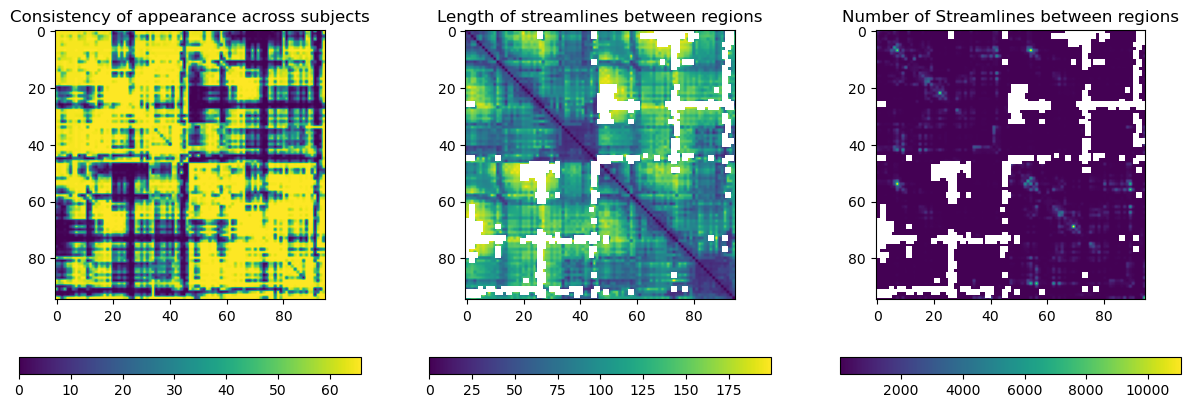

In [20]:
# Ploting the stats view
fig, ax = plt.subplots(1,3, figsize=(15,5))
im0 = ax[0].imshow(consistency_view)
im1 = ax[1].imshow(length_view)
im2 = ax[2].imshow(nbStlines_view)
ax[0].set_title('Consistency of appearance across subjects')
ax[1].set_title('Length of streamlines between regions')
ax[2].set_title('Number of Streamlines between regions')
fig.colorbar(im0,  orientation='horizontal')
fig.colorbar(im1,  orientation='horizontal')
fig.colorbar(im2,  orientation='horizontal')

### StreamLines specifics

In [21]:
streamline = get_bundles_betweenreg(hf, 3,78)

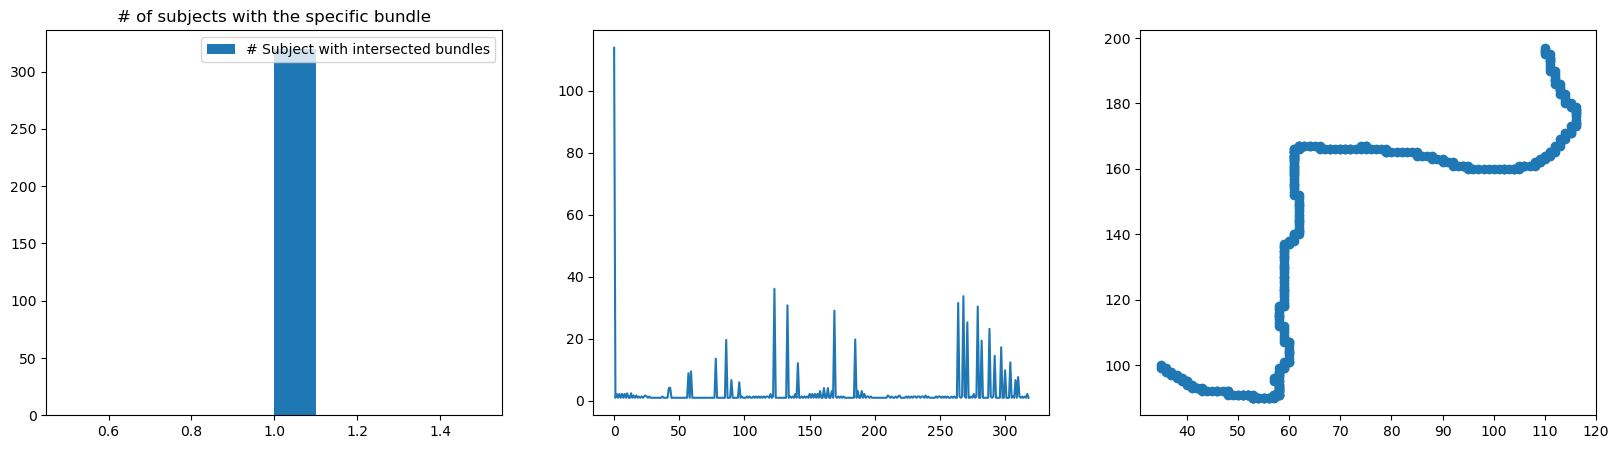

In [22]:
path_motion = []
coords = streamline[:,[0,1,2]]
for k in range(streamline.shape[0]-1):
    dist = np.sqrt(np.sum((coords[k] - coords[k-1]) ** 2))
    path_motion.append(dist)

fig ,ax = plt.subplots(1,3, figsize=(20,5))
ax[0].hist(streamline[:,3], label='# Subject with intersected bundles')
ax[0].set_title('# of subjects with the specific bundle')
ax[0].legend()
ax[1].plot(path_motion)
ax[2].scatter(coords[:,0],coords[:,1])
# plt.xlim(0,100)

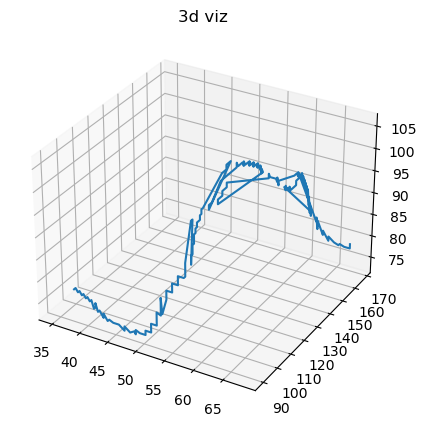

In [23]:
fig,axs = plt.subplots(1,1,subplot_kw=dict(projection='3d'),figsize=(5,5))

length_order = 200
x=coords[:,0][:length_order]
y=coords[:,1][:length_order]
z=coords[:,2][:length_order]

axs.plot(x,y,z)
axs.set_title('3d viz')
plt.show()

### Computing seed connectivity between regions Atlased

Idea is to obtain a $y$ value for each of the fibers to compute connectivity

In [24]:
def mean_fmri(nifti):
    """
    Compute mean (across time) fmri volume
    """

    affine = nifti.affine
    volume = nifti.get_fdata()
    mean_volume = volume.mean(axis=-1)
    ret = nib.Nifti1Image(mean_volume, affine=affine)
    return ret

def abs_nifti(nifti):
    """
    Compute absolute value nifti file
    """

    affine = nifti.affine
    volume = nifti.get_fdata()    
    ret = nib.Nifti1Image(np.abs(volume), affine=affine)
    return ret

In [25]:
rest_affine = rst_vol.affine

(-2.0, -29.0, 39.0)

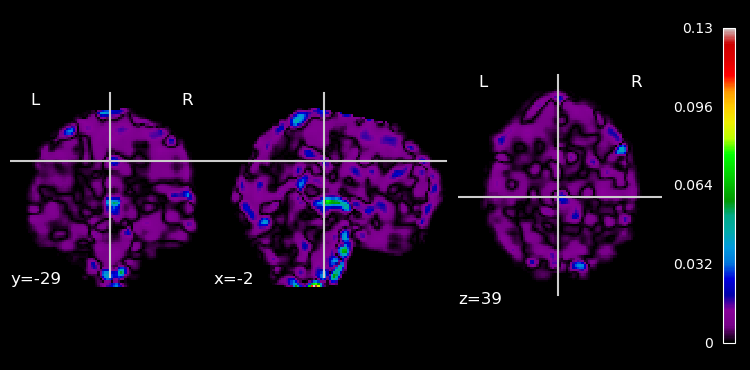

In [28]:
# Visualizing the original fmri
from nilearn import plotting
from nilearn.plotting import plot_epi, show
# @ PCC
plot_epi(abs_nifti(mean_fmri(rst_vol)), colorbar=True, cut_coords=(-2,-29,39))
nimg.coord_transform(46,48.5,55.5, rest_affine) # PCC coordinates

In [29]:
ftimecourse = rst_vol.get_fdata()

In [30]:
seedfunc_vol = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol.shape[0])):
    for y in range(seedfunc_vol.shape[1]):
        for z in range(seedfunc_vol.shape[2]):
            seedfunc_vol[x,y,z] = pearsonr(ftimecourse[46,48,55], ftimecourse[x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [02:44<00:00,  1.81s/it]


/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


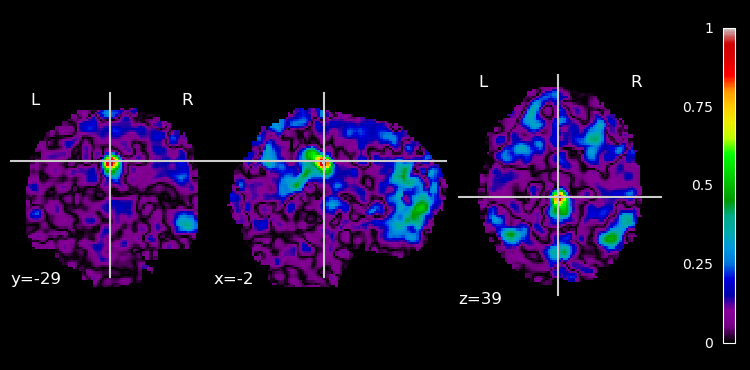

In [31]:
# Visualizing the functional connectivity strength by seed connectivity (seed -> PCC)
plot_epi(abs_nifti(nib.Nifti1Image(seedfunc_vol, affine=rest_affine)), colorbar=True, cut_coords=(-2,-29,39))

In [32]:
from nilearn import image
from tqdm import tqdm

# 1. Transform the voxels to coordinates
# 2. Match the coordinates i.e the voxels to a given label
# 3. Obtain an mapping of a voxel to the parcels

labels_vol = np.zeros(rst_vol.shape[:3])
for x in tqdm(range(rst_vol.shape[0])):
    for y in range(rst_vol.shape[1]):
        for z in range(rst_vol.shape[2]):
            # Find the MNI coordinates of the voxel (x, y, z)
            spatial_coord = np.array(image.coord_transform(x, y, z, rst_vol.affine))
            labels_vol[x,y,z] = np.argmin(np.sum((centers - spatial_coord) ** 2, axis=1))

# Atlas averaging timecourses
avg_tc = np.zeros((centers.shape[0], rst_vol.shape[-1]))
for t in tqdm(range(rst_vol.shape[-1])):
    tmp = rst_vol.get_fdata()[:,:,:,t]
    for k in range(centers.shape[0]):
        indexes = (labels_vol == k)
        nonzero = tmp[indexes][(tmp[indexes] != 0)]
        avg_tc[k,t] = nonzero.mean()

100%|██████████| 460/460 [00:31<00:00, 14.69it/s]


In [33]:
corr_mat = np.zeros((avg_tc.shape[0],avg_tc.shape[0]))
for k in range(avg_tc.shape[0]):
    corr_mat[k] = nta.SeedCorrelationAnalyzer(avg_tc[k], avg_tc).corrcoef

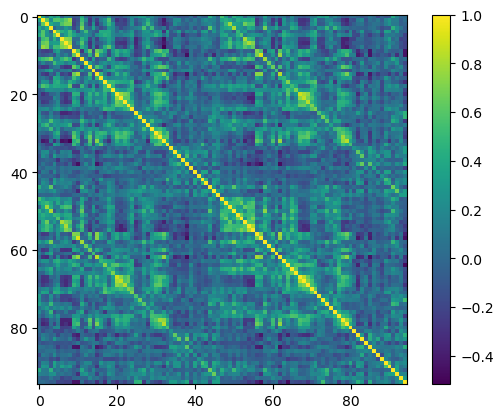

In [34]:
plt.imshow(corr_mat)
plt.colorbar()

### Computing regularized regression on fibers combination for seed functional connectivity explanation

1. End-region encoded vectors

In [35]:
# Generating the X samples and the y samples
# 1. Careful as well to remove the auto-correlation in the diagonal
# 2. Raster scan parsing meaning that it is the activity of (R0,R1) -> (R0,R2) -> (R0,R3) etc...
# Define matrix of end points on cortex
X = []
bundles_labels = []
pairs = np.zeros((nb_regions, nb_regions))
for i in tqdm(range(1,nb_regions + 1)):
    for j in range(i,nb_regions + 1):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None: continue
        bundles_labels.append((i,j))
        pairs[i-1,j-1] = 1.0
        vec = np.zeros(nb_regions)
        vec[i-1] = 1.0
        vec[j-1] = 1.0
        X.append(vec)

X = np.asarray(X)

  0%|          | 0/95 [00:00<?, ?it/s]

100%|██████████| 95/95 [00:29<00:00,  3.18it/s]


In [36]:
y = (corr_mat - np.eye((nb_regions))).mean(axis=0)

In [37]:
regularizers = np.sort(np.concatenate([np.logspace(0,5,6), np.logspace(0,5,6) / 2]))

coefs = []
scores = []
for k in tqdm(range(len(regularizers))):
    clf = Ridge(alpha=regularizers[k])
    clf.fit(X.T, y)
    scores.append(clf.score(X.T,y))
    coefs.append(clf.coef_)

100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


In [38]:
regularizers_lasso = np.sort(np.concatenate([np.logspace(-5,0,6), np.logspace(-5,0,6) / 2]))
coefs_lasso = []
scores_lasso = []
for k in tqdm(range(len(regularizers_lasso))):
    clf = Lasso(alpha=regularizers_lasso[k])
    clf.fit(X.T, y)
    scores_lasso.append(clf.score(X.T,y))
    coefs_lasso.append(clf.coef_)

100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


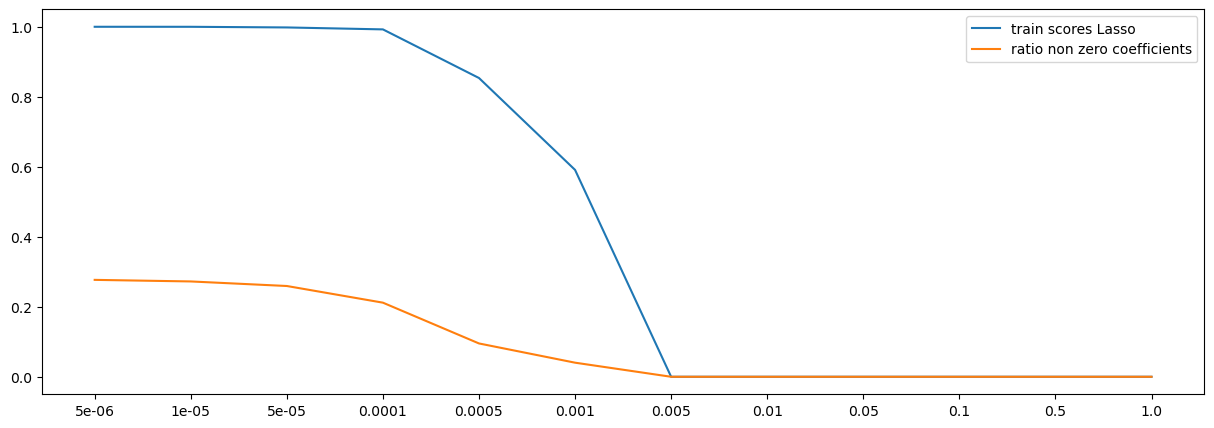

In [40]:
coefs_sum = [np.mean(c!=0)for c in coefs_lasso]
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(scores_lasso, label='train scores Lasso')
ax.plot(coefs_sum, label='ratio non zero coefficients')
ax.set_xticks(np.arange(len(regularizers_lasso)))
ax.set_xticklabels(regularizers_lasso)
ax.legend()
scores_lasso[np.argmax(np.abs(np.diff(scores_lasso)))-1]
# ax.ticklabel_format(style='sci')

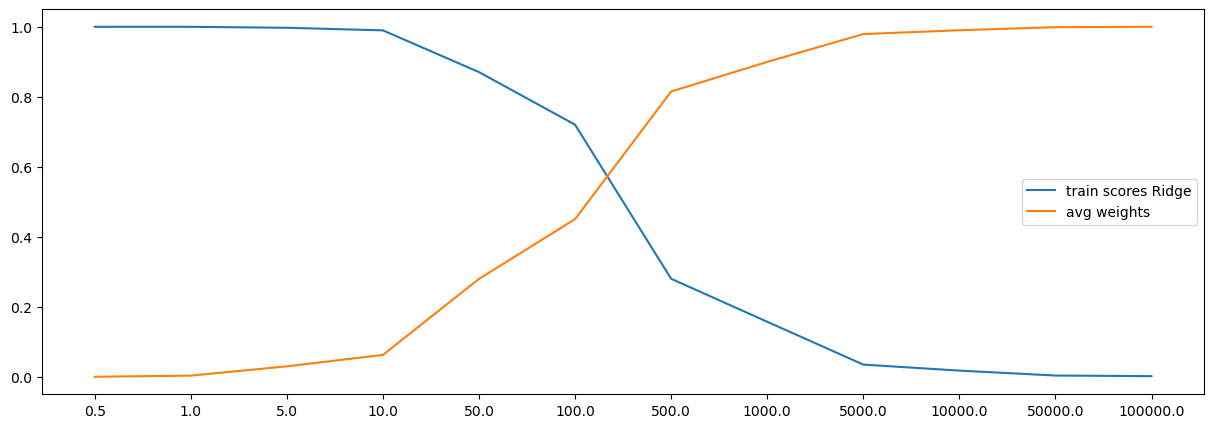

In [41]:
coefs_sum = np.array([np.mean(c)for c in coefs])
coefs_sum = coefs_sum-coefs_sum.min()
coefs_sum /= coefs_sum.max()
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(scores, label='train scores Ridge')
ax.plot(coefs_sum, label='avg weights')
ax.set_xticks(np.arange(len(regularizers)))
ax.set_xticklabels(regularizers)
ax.legend()
# ax.ticklabel_format(style='sci')

Bundle probability regularizer accounted linear regression

In [72]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(764, 100, dtype=torch.float16),
)

In [117]:
# Compute a regularizer taking into account the probability of a voxel belonging to the fibers
# Here is the loss we consider

sparsing_distrib = 2
Cscale1 = (np.array([consistency_view[p[0]-1,p[1]-1]/nsubject for p in bundles_labels])) ** sparsing_distrib

def consistency_regularizer(x, C, lbd):
    """
    Compute regularizer dependent on consistency following:
    Lower consistency increase penalization
    """
    inv_C = (1 / C)
    ret = lbd * np.sum((inv_C * x) ** 2) / C.shape[0]
    return ret

In [124]:
consistency_regularizer(coefs_lasso[2], Cscale1, 1)

3.3492966732599943

In [120]:
consistency_regularizer(coefs_lasso[0], Cscale1, 1)

3.371967479931501

In [119]:
consistency_regularizer(coefs_lasso[4], Cscale1, 1)

2.218566100876978

### Reconstruction of the fMRI timecourses in WM bundles / voxels levels

- Bring back the GM voxel level timecourses
- Assign timecourse value on voxel being the weighted value of a voxel (so can regenerate WM volumes first then average)
- Recompute the seed connectivity of a given region versus all and show it on the volume (voxel levels)

In [42]:
bundle_affine = np.array(hf.get('header').get('affine'))[()]

In [43]:
def volcoord2mnicoord(arrays, affine):
    """
    Compute volume coords to mni coords transform
    """
    # ret = []
    # for arr in arrays:
    #     ret.append(nimg.coord_transform(arr[0],arr[1],arr[2], affine))
    tmp = np.concatenate([arrays,np.ones((arrays.shape[0],1))], axis=1)
    ret = np.matmul(affine,tmp.T)[:3].T

    return np.array(ret).astype(float)

def mnicoord2volcoord(arrays, affine):
    """
    Compute volume coords from mni coords transform
    """
    inv_affine = np.linalg.inv(affine)
    # ret = []
    # for arr in arrays:
    #     ret.append(nimg.coord_transform(arr[0],arr[1],arr[2], inv_affine))
    tmp = np.concatenate([arrays,np.ones((arrays.shape[0],1))], axis=1)
    ret = np.matmul(inv_affine,tmp.T)[:3].T

    return np.array(ret).astype(int)

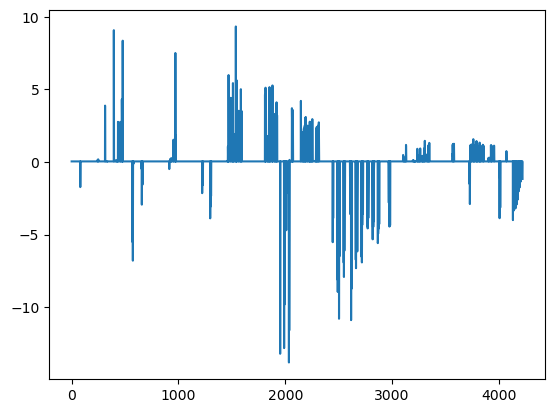

In [44]:
# Coefs chosen and regularizers choen
coefs2use = zscore(coefs_lasso[4])
plt.plot(coefs2use)

Making Access easier - transforming bundles to fmri coordinates / fmri volumes masks

In [45]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_coords = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    fmri_coords.append(volcoords_interest)

100%|██████████| 4222/4222 [07:05<00:00,  9.91it/s]


In [46]:
# Save the space coords matching
save('./resources/scale1_fmri2atlas_coords.pkl', fmri_coords)

In [61]:
trans_affine = np.matmul(np.linalg.inv(rest_affine), bundle_affine)

fmri_masks = []
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    streamline = get_bundles_betweenreg(hf, i,j)
    # Transform voxel indexes of a volume to voxel index of another volume
    volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)

    # fmri_coords.append(volcoords_interest)
    tmp_mask = np.zeros_like(ftimecourse[:,:,:,0])
    for coord in volcoords_interest:
        x,y,z = coord
        tmp_mask[x,y,z] = 1.0
    fmri_masks.append(tmp_mask)

100%|██████████| 4222/4222 [12:08<00:00,  5.79it/s]


In [62]:
# Save the space coords matching
save('./resources/scale1_fmri2atlas_mask.pkl', fmri_masks)

Interpolate the connectivity or fMRI timecourse of WM bundles at voxel levels

In [53]:
# Iterate across all the bundles and populate each voxels by the timcourses
wm_inpainted = np.zeros_like(ftimecourse)
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    volcoords_interest = fmri_coords[k]
    avg_betweenbundle_course = (avg_tc[i-1] + avg_tc[j-1])/2

    for coord in volcoords_interest:
        x,y,z = coord
        wm_inpainted[x,y,z,:] = wm_inpainted[x,y,z,:] + coefs2use[k] *  avg_betweenbundle_course

100%|██████████| 4222/4222 [15:15<00:00,  4.61it/s] 


In [54]:
seedfunc_vol_WM = np.zeros((ftimecourse.shape[:-1]))
for x in tqdm(range(seedfunc_vol_WM.shape[0])):
    for y in range(seedfunc_vol_WM.shape[1]):
        for z in range(seedfunc_vol_WM.shape[2]):
            seedfunc_vol_WM[x,y,z] = pearsonr(wm_inpainted[46,48,55], wm_inpainted[x,y,z])[0]

  0%|          | 0/91 [00:00<?, ?it/s]/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
100%|██████████| 91/91 [02:00<00:00,  1.32s/it]


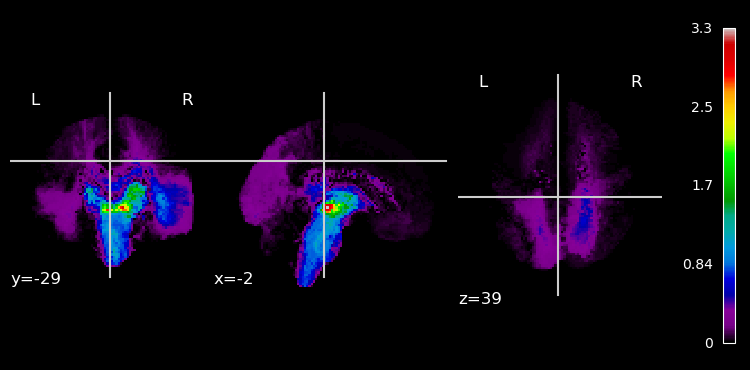

In [55]:
plot_epi(abs_nifti(mean_fmri(nib.Nifti1Image(wm_inpainted, affine=rest_affine))), colorbar=True, cut_coords=(-2,-29,39))

/Users/mikichan/miniconda3/envs/microstruct_atlasing/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


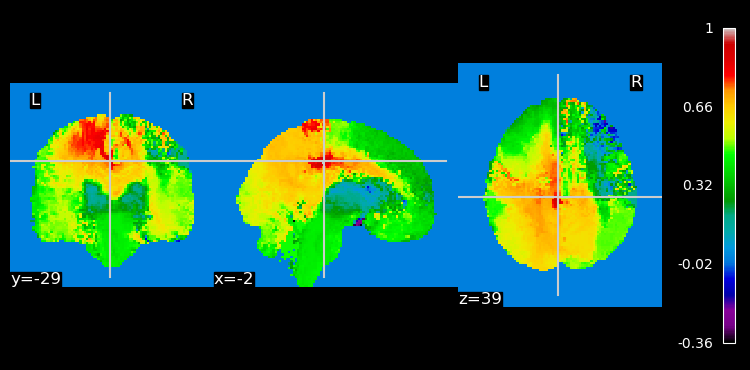

In [56]:
# Visualizing the functional connectivity strength by seed connectivity (seed -> PCC)
plot_epi(nib.Nifti1Image(seedfunc_vol_WM, affine=rest_affine), colorbar=True, cut_coords=(-2,-29,39))

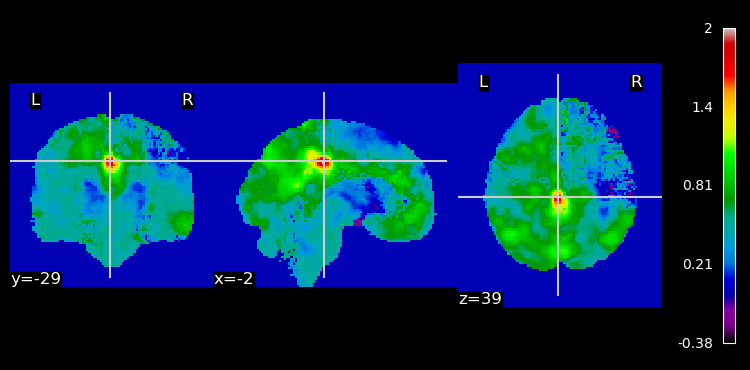

In [57]:
plot_epi(nib.Nifti1Image(seedfunc_vol + seedfunc_vol_WM, affine=rest_affine), colorbar=True, cut_coords=(-2,-29,39))

In [58]:
# Iterate across all the bundles and populate each voxels by the timcourses
wm_inpainted_conn = np.zeros_like(ftimecourse[:,:,:,0])
for k in tqdm(range(len(bundles_labels))):
    i,j = bundles_labels[k]
    # volcoords_interest = volcoord2mnicoord(streamline[:,[0,1,2]], trans_affine).astype(int)
    volcoords_interest = fmri_coords[k]
    avg_betweenbundle_conn = corr_mat[i-1,j-1]
    for coord in volcoords_interest:
        x,y,z = coord
        wm_inpainted_conn[x,y,z] = wm_inpainted_conn[x,y,z] + coefs2use[k] *  avg_betweenbundle_conn

  0%|          | 0/4222 [00:00<?, ?it/s]

100%|██████████| 4222/4222 [02:36<00:00, 26.92it/s] 


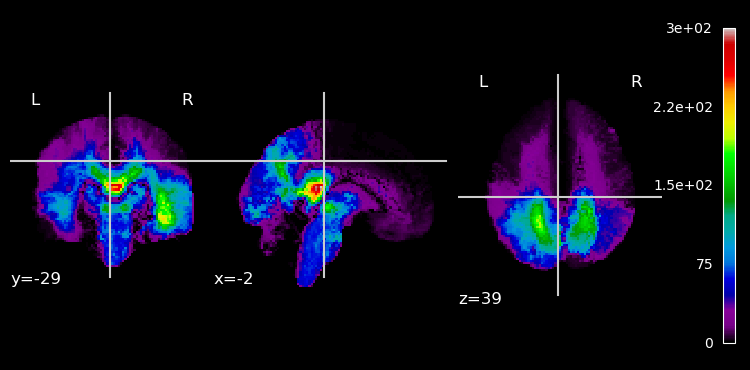

In [59]:
plot_epi(abs_nifti(nib.Nifti1Image(wm_inpainted_conn, affine=rest_affine)), colorbar=True, cut_coords=(-2,-29,39))

In [ ]:
# NOTE: Close the opened h5 file
hf.close()

2. Intersection of bundles considered as hot-one encoded

In [18]:
# Compute which bundles have intersecting voxels, basically a intersection matrix would be our X samples matrix
allstreamlines = []
actualstreamlines = []
for i in tqdm(range(1,96)):
    for j in range(i+1,96):
        tmp = get_bundles_betweenreg(hf, i, j, verbose=False)
        if tmp is None:
            allstreamlines.append(tmp)
        else:
            allstreamlines.append(tmp[:,[0,1,2]])
            actualstreamlines.append(tmp[:,[0,1,2]])

100%|████████████████████████████████████████████████████████████████| 95/95 [00:48<00:00,  1.96it/s]


In [19]:
voxels = set(tuple(map(tuple, actualstreamlines[0])))
for k in tqdm(range(len(actualstreamlines))):
    voxels = voxels.union(set(tuple(map(tuple, actualstreamlines[k]))))

100%|████████████████████████████████████████████████████████████| 4222/4222 [21:50<00:00,  3.22it/s]


In [ ]:
S = []
for k in tqdm(range(len(allstreamlines))):
    if not (allstreamlines[k] is None):
        S.append(set(tuple(map(tuple, allstreamlines[k]))))
    else:
        S.append(None)

 80%|███████████████████████████████████████████████▊            | 3558/4465 [02:18<00:50, 17.88it/s]

In [ ]:
streamline_conn = np.zeros((len(allstreamlines),len(allstreamlines)))
for k in tqdm(range(len(allstreamlines))):
    # for each streamline look for all the other streamlines that might have intersecting voxels and if yes then flip
    template = S[k]
    if template is None:
        streamline_conn[k,:] = np.nan
        continue
    for m in range(len(allstreamlines)):
        database = S[m]
        if database is None:
            streamline_conn[k,m] = np.nan
            continue
        streamline_conn[k,m] = len(template.intersection(database))

In [92]:
# np.save('intersect_bndles.npy',streamline_conn)
# np.load('intersect_bndles.npy')

/tmp/ipykernel_2804820/2929158981.py:3: RuntimeWarning: invalid value encountered in divide
  X = X/X.max(axis=0)


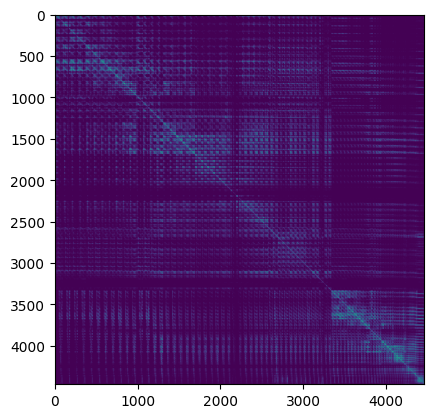

In [65]:
# 1. Standardize count
X = np.nan_to_num(streamline_conn)
X = X/X.max(axis=0)
X = np.nan_to_num(X)

plt.imshow(X)
plt.show()

# 2. Binarize it by thresholding
X = (X > 0.5).astype(float)

Linear regression fitting

In [27]:
y = corr_mat[np.triu_indices(corr_mat.shape[0], 1)]

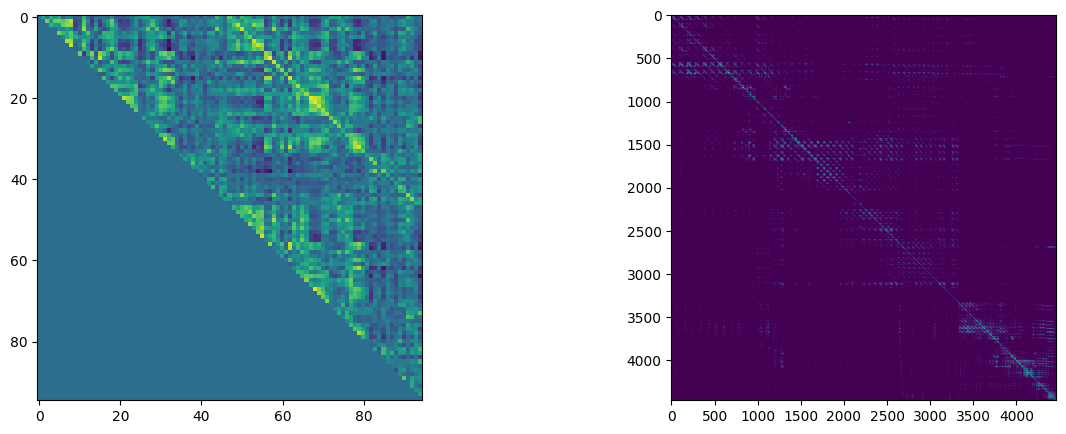

In [66]:
# Example of connectivity we will be using as a set of y samples
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(np.triu(corr_mat, 1))
ax[1].imshow(X)